# Explanation of the following mess:

## Data analysis and pre processing

Variables were selected based on "economics" intuition. This means, what are the drivers of choices of people. Some of these variables (although not an exhaustive list) are: income, municipality of residency, main occupation, etc. individuals with missing values were dropped. I am aware of the loss of information implied in this, however, the model is already complex and modeling the missing values would be an unnecessary added complexity. 

## Model

As exposed on the previous milestone, the model I am working in is a state space model where the hidden state depends on both previous hidden states, socio-economic factors and spatio-temporal factors. In this milestone, these relations are lineal, however, in future work it would be ideal to have non-linearities between these variables. The hidden state size is a hyperparameter we have to fix before the estimation. The hidden state, is useful for different classification and regression tasks. Using the hidden-state I will predict the activity of the person, the location of the activity, the mode chosen and the dwell time. All these tasks have to be worked out with a non so highly dimensional hidden state. 

Furthermore, it would be interesting to see these hidden states on a low dimension plot, intuition would say that these are some form of probabilistic embeddings and they can convey even further information of the individuals in the dataset. 

### Implementation challanges

Even though the model is completely programmed, there are some bugs in it. The last one I have detected which I havent corrected are the integers used for the categorical logit. They have to be ordered and cannot take arbitrary values as they come on the dataset, I will work on that during this week and hopefully would be able to run the model during the weekend. 

## Next steps

Some interesting directions in which I can take this model are:
- The implementation of non-linearities on the relations between variables and hidden-state
- The implementation of the dwell time as a mixture of distributions
- The implementation of missing values imputation

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import pystan

In [2]:
# Pandas options
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 150)

In [3]:
# Data path
data_path = '/mnt/sdb1/data_shgm/TU0616_csv/'

In [4]:
# Trips data which is going to be merged with the session dataset
trip_df = pd.read_csv(os.path.join(data_path, 'tur.csv'))

In [5]:
trip_df.shape # (429371, 74)

(429371, 74)

In [6]:
#trip_df.columns

In [7]:
trip_df.head()

,TurId,SessionId,TurNr,TripCount,DepartHH,DepartMM,DepartMSM,ArrivalHH,ArrivalMM,ArrivalMSM,DestDwelTime,OrigNUTS,OrigMuncode,OrigOldMuncode,OrigCityCode,OrigNTMzone,OrigNearestStation,OrigDistNearestStation,DestNUTS,DestMuncode,DestOldMuncode,DestCityCode,DestNTMzone,DestNearestStation,DestDistNearestStation,OrigPurp,DestPurp,DestEscortPurp,TripPurp,TripPurpGroup,SimplWorktour,SimplWorkNumstop,GISdist,NumModes,SumLen,SumMin,SumMotorLen,SumMotorMin,ModeChainType,PrimMode,PrimModeDrivPass,SecMode,PrimModeSumlen,SecModeSumlen,FirstMode,LastMode,PartyorAlone,PartyNumu10,PartyNum1017,PartyNumAdults,BicType,CarPassDriver,CarPassContext,CarUsageCarNo,PtTicketType,PtPrice,PtBicType,PtPrimMode,PtAccMode,PtEgrMode,PtAccLen,PtEgrLen,FirstStation,LastStation,TrainMode,TrainAccMode,TrainEgrMode,TrainAccLen,TrainEgrLen,TrainAccDist,TrainEgrDist,JourneyId,JourneyRole,GISdistJourneyStartP
0,47,50026,1,1.0,9.0,30.0,570.0,10.0,25.0,625.0,605.0,DK041,657.0,657.0,11007.0,657133.0,Herning ...,1.1,DK041,779.0,779.0,10791.0,779142.0,Skive ...,3.6,1.0,41.0,NaN,41,40,2,NaN,50.79,1.0,55.0,55.0,55.0,55.0,11.0,11.0,1.0,NaN,55.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,1.0,50.8
1,48,50026,2,1.0,20.0,30.0,1230.0,21.0,25.0,1285.0,NaN,DK041,779.0,779.0,10791.0,779142.0,Skive ...,3.6,DK041,657.0,657.0,11007.0,657133.0,Herning ...,1.1,41.0,1.0,NaN,41,40,2,NaN,50.79,1.0,55.0,55.0,55.0,55.0,11.0,11.0,1.0,NaN,55.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0.0,0.0
2,49,50027,1,1.0,9.0,5.0,545.0,9.0,10.0,550.0,20.0,DK041,779.0,779.0,10791.0,779154.0,Skive ...,3.3,DK041,779.0,779.0,10791.0,779152.0,Skive ...,1.1,1.0,41.0,NaN,41,40,2,NaN,2.20,1.0,2.0,5.0,2.0,5.0,11.0,11.0,1.0,NaN,2.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,21.0,2.2
3,50,50027,2,1.0,9.0,30.0,570.0,9.0,40.0,580.0,35.0,DK041,779.0,779.0,10791.0,779152.0,Skive ...,1.1,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.8,41.0,31.0,NaN,31,30,2,NaN,2.12,1.0,3.5,10.0,3.5,10.0,11.0,11.0,1.0,NaN,3.5,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,1.0,2.6
4,51,50027,3,1.0,10.0,15.0,615.0,10.0,25.0,625.0,0.0,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.8,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.1,31.0,49.0,NaN,31,30,2,NaN,1.30,1.0,2.5,10.0,2.5,10.0,11.0,11.0,1.0,NaN,2.5,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,NaN,3.5


/home/shgm/shgm/ModelBased/env_mbml/lib/python3.5/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shgm/shgm/ModelBased/env_mbml/lib/python3.5/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


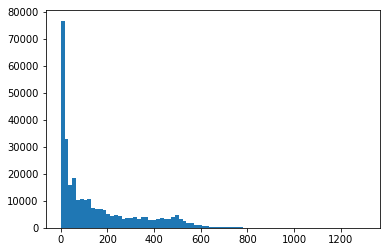

In [8]:
plt.hist(trip_df.DestDwelTime, bins=80); 
# Time people stay in the place they were meant to. It seems like a mixture of an exp distribution and a normal distribution
#  This could be a hint of two types of trips: one which is the "ocassional" trip: shopping, visits, etc and "work related" trip

In [9]:
trip_df.TripPurpGroup.value_counts()

40    155394
30    148699
11     82023
12     28027
50     15228
Name: TripPurpGroup, dtype: int64

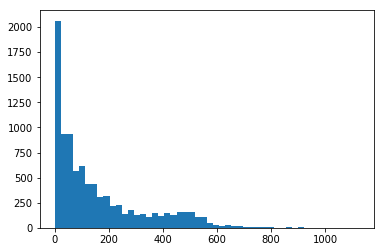

In [10]:
plt.hist(trip_df.DestDwelTime[trip_df.TripPurpGroup==50], bins=50); 

In [11]:
# The variables of interest from the tur dataset are:
trip_vars = [
    'SessionId',
    'TurNr',
    'PrimMode',
    'DepartHH', # Potentially DepartMM
    'OrigMuncode',
    'DestMuncode',
    'TripPurpGroup',
    'DestDwelTime'
]

In [12]:
# Socioeconomic dataset which is merged with the trips data, the datasets are merged using the 'SessionID' variable where the 
#  socioeconomic variables are repeated across trips
socio_df = pd.read_csv(os.path.join(data_path, 'session.csv'))

In [13]:
socio_df.head()

,SessionId,InterviewType,DiaryDate,DiaryYear,PseudoYear,DiaryMonth,DiaryWeekday,DiaryDaytype,HomeAdrNUTS,HomeAdrMunCode,HomeAdrOldMuncode,HomeAdrCityCode,HomeAdrCitySize,HomeAdrNTMzone,HomeAdrNearestStation,HomeAdrDistNearestStation,HomeParkPoss,RespSex,RespYearBorn,RespAgeSimple,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,PrimOccOldMuncode,PrimOccNTMzone,WorkHoursPw,WorkHourType,WorkPubPriv,WorkatHomeDayspM,SduMuncode,SduOldMuncode,SduNTMzone,GISdistHW,kmarbud,HwDayspW,HwDaysReason,WorkParkPoss,RespHasBicycle,RespHasSeasonticket,RespHasRejsekort,ResphasDrivlic,RespDrivlicYear,RespIsmemCarshare,HousehNumcars,HousehCarOwnership,Handicap,HousehAccomodation,HousehAccOwnorRent,IncRespondent,IncRespondent2000,IncSpouse,IncSpouse2000,IncNuclFamily,IncNuclFamily2000,IncFamily,IncFamily2000,IncHouseh,IncHouseh2000,NuclFamType,PosInFamily,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumDrivLic,DayStartNUTS,DayStartMuncode,DayStartOldMuncode,DayStartCityCode,DayStartNTMzone,DayStartJourneyRole,DayStartPurp,RespNotripReason,NightsAway,TotalNumTrips,NumTripsCorr,NumTripsExclComTrans,TotalLen,TotalLenExclComTrans,TotalMotorLen,TotalBicLen,TotalMin,TotalMotorMin,PrimModeDay,ModeChainTypeDay,DayNumJourneys,JstartType,JstartMuncode,JstartNTMzone,JstartNearestStation,JstartDistNearestStation,DayJourneyType,DayPrimTargetMuncode,DayPrimTargetPurp,SessionWeight
0,50068,0,13281,2006,2006/7,5,6,23,DK013,230,181.0,10289.0,7752.0,230045.0,Nærum ...,3.4,NaN,2,1967,39,38,30.0,11.0,230.0,181.0,230044.0,48.0,NaN,2.0,14.0,230.0,181.0,230045.0,1.6,5.0,1.0,4.0,11.0,2.0,2,NaN,1.0,1985.0,2.0,2.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,12.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,DK013,230.0,181.0,10289.0,230045.0,0.0,1.0,13.0,NaN,0,0,0,0.0,0.0,0.0,0.0,0,0,NaN,NaN,0.0,3.0,230.0,230045.0,Nærum ...,3.4,1,230.0,1.0,204.182196
1,50070,0,13282,2006,2006/7,5,7,32,DK012,159,159.0,1100.0,1084885.0,159074.0,Stengården ...,0.4,NaN,1,1993,13,12,1.0,1.0,159.0,159.0,159073.0,NaN,NaN,NaN,NaN,159.0,159.0,159074.0,0.5,0.9,5.0,NaN,12.0,1.0,2,NaN,-18.0,NaN,NaN,1.0,0.0,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,20.0,4.0,2.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,2.0,4.0,1.0,DK012,159.0,159.0,1100.0,159074.0,0.0,1.0,13.0,NaN,0,0,0,0.0,0.0,0.0,0.0,0,0,NaN,NaN,0.0,3.0,159.0,159074.0,Stengården ...,0.4,1,159.0,1.0,495.028999
2,50071,0,13282,2006,2006/7,5,7,32,DK011,101,101.0,1100.0,1084885.0,102151.0,Nørreport ...,0.4,NaN,1,1973,33,32,30.0,11.0,230.0,181.0,230031.0,37.0,NaN,1.0,0.0,101.0,101.0,102151.0,14.9,15.0,5.0,NaN,11.0,1.0,2,NaN,1.0,1992.0,2.0,1.0,1.0,2.0,NaN,3.0,330.0,293.0,240.0,213.0,570.0,506.0,570.0,506.0,570.0,506.0,20.0,11.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,DK011,101.0,101.0,1100.0,102151.0,0.0,1.0,NaN,NaN,2,2,2,0.6,0.6,0.0,0.0,10,0,1.0,1.0,1.0,2.0,101.0,102151.0,Nørreport ...,0.4,11,101.0,31.0,460.598736
3,50072,0,13282,2006,2006/7,5,7,32,DK050,840,833.0,10783.0,406.0,840052.0,Hobro ...,8.3,NaN,2,1960,46,45,30.0,5.0,840.0,833.0,840053.0,30.0,NaN,2.0,0.0,840.0,833.0,840052.0,5.2,5.0,5.0,NaN,11.0,1.0,2,NaN,1.0,1978.0,2.0,1.0,0.0,2.0,1.0,1.0,190.0,168.0,310.0,275.0,500.0,444.0,500.0,444.0,500.0,444.0,21.0,12.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,DK050,840.0,833.0,10783.0,840052.0,0.0,1.0,NaN,NaN,2,2,2,150.0,150.0,150.0,0.0,150,150,11.0,11.0,1.0,2.0,840.0,840052.0,Hobro ...,8.3,11,661.0,41.0,113.629100
4,50073,0,13282,2006,2006/7,5,7,32,DK012,183,183.0,1100.0,1084885.0,183013.0,Ishøj ...,0.9,NaN,1,1946,60,59,30.0,3.0,165.0,165.0,165011.0,37.0,NaN,1.0,0.0,183.0,183.0,183013.0,7.4,NaN,5.0,NaN,11.0,1.0,2,NaN,1.0,1965.0,2.0,1.0,1.0,2.0,1.0,1.0,410.0,364.0,246.0,218.0,656.0,583.0,656.0,583.0,656.0,583.0,20.0,11.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,DK022,360.0,383.0,0.0,360144.0,1.0,44.0,NaN,NaN,1,1,1,146.0,146.0,146.0,0.0,85,85,11.0,11.0,0.5,2.0,183.0,183013.0,Ishøj

In [14]:
socio_df = socio_df.sample(frac=0.1, random_state=42)

In [15]:
# The variables of interest from the session dataset are:
socio_vars = [
    'SessionId',
    'DiaryMonth',
    'DiaryWeekday',
    'DiaryDaytype',
    'HomeAdrMunCode',
    'RespSex',
    'RespAgeCorrect',
    'RespMainOccup',
    'RespEdulevel',
    'PrimOccMuncode',
    'RespHasBicycle',
    'RespHasSeasonticket',
    'HousehCarOwnership',
    'IncRespondent2000',
    'FamNumPers',
    'FamNumAdults', # To know if they have kids
]

In [16]:
trip_df  = trip_df[trip_vars]
socio_df = socio_df[socio_vars]

In [17]:
# Create the kids variable
# Does the family have kids?
socio_df['kids'] = socio_df.FamNumPers-socio_df.FamNumAdults

# Drop redundant variables
socio_df = socio_df.drop(['FamNumPers', 'FamNumAdults'], axis=1)

# Drop nans in the socio dataset after subsetting the variables. A more elegant approach would be to assume a distribution on the variables with missing values. This is left to future work
socio_df = socio_df.dropna()
socio_df.shape

# Turn variables into int type
socio_df = socio_df.astype('int')

In [18]:
df = trip_df.merge(socio_df, how='left', on='SessionId')

In [19]:
df.head()

,SessionId,TurNr,PrimMode,DepartHH,OrigMuncode,DestMuncode,TripPurpGroup,DestDwelTime,DiaryMonth,DiaryWeekday,DiaryDaytype,HomeAdrMunCode,RespSex,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,RespHasBicycle,RespHasSeasonticket,HousehCarOwnership,IncRespondent2000,kids
0,50026,1,11.0,9.0,657.0,779.0,40,605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50026,2,11.0,20.0,779.0,657.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50027,1,11.0,9.0,779.0,779.0,40,20.0,5.0,5.0,33.0,779.0,1.0,51.0,30.0,11.0,779.0,1.0,2.0,2.0,297.0,0.0
3,50027,2,11.0,9.0,779.0,779.0,30,35.0,5.0,5.0,33.0,779.0,1.0,51.0,30.0,11.0,779.0,1.0,2.0,2.0,297.0,0.0
4,50027,3,11.0,10.0,779.0,779.0,30,0.0,5.0,5.0,33.0,779.0,1.0,51.0,30.0,11.0,779.0,1.0,2.0,2.0,297.0,0.0


In [20]:
df.shape

(429371, 22)

In [21]:
# Gets the list of session ids which have null values in any variable different from destdweltime (since all ids have nan there)
drop_idx = list(set(df.SessionId[df[set(df)-set(['DestDwelTime'])].isnull().any(axis=1)])) 
df = df.drop(pd.Index(np.where(df['SessionId'].isin(drop_idx))[0])).reset_index(drop=True)

In [22]:
df.shape

(24965, 22)

In [23]:
N_trips = df.groupby('SessionId').max().reset_index()[['SessionId', 'TurNr']]
# Gets the list of session ids which have a value of 1 on the max number of trips since we are interested in modeling sequences
drop_idx = list(N_trips.SessionId[N_trips.TurNr==1])
df = df.drop(pd.Index(np.where(df['SessionId'].isin(drop_idx))[0]))
N_trips = df.groupby('SessionId').max().reset_index()[['SessionId', 'TurNr']]

In [24]:
df.sort_values(by=['SessionId', 'TurNr'], inplace=True)
N_trips.sort_values(by='SessionId', inplace=True)
trip_idx = N_trips['TurNr'].cumsum()

In [25]:
df[list(set(df)-set(['DestDwelTime']))] = df[list(set(df)-set(['DestDwelTime']))].astype('int')

In [26]:
# Different parametrization of time so we make sure that 11:59pm is close to 12:00am I have to include minutes next time, of course
df['HH_1'] = np.sin(2*np.pi*df.DepartHH/24)
df['HH_2'] = np.cos(2*np.pi*df.DepartHH/24)

# Drop redundant variables
df = df.drop(['DepartHH'], axis=1)

In [27]:
df.head()

,SessionId,TurNr,PrimMode,OrigMuncode,DestMuncode,TripPurpGroup,DestDwelTime,DiaryMonth,DiaryWeekday,DiaryDaytype,HomeAdrMunCode,RespSex,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,RespHasBicycle,RespHasSeasonticket,HousehCarOwnership,IncRespondent2000,kids,HH_1,HH_2
0,50027,1,11,779,779,40,20.0,5,5,33,779,1,51,30,11,779,1,2,2,297,0,0.707107,-0.707107
1,50027,2,11,779,779,30,35.0,5,5,33,779,1,51,30,11,779,1,2,2,297,0,0.707107,-0.707107
2,50027,3,11,779,779,30,0.0,5,5,33,779,1,51,30,11,779,1,2,2,297,0,0.500000,-0.866025
3,50027,4,11,779,779,40,3.0,5,5,33,779,1,51,30,11,779,1,2,2,297,0,0.500000,-0.866025
4,50027,5,11,779,779,40,0.0,5,5,33,779,1,51,30,11,779,1,2,2,297,0,0.500000,-0.866025


In [28]:
list_ST = ['OrigMuncode', 'DiaryMonth', 'DiaryWeekday', 'DiaryDaytype', 'HH_1', 'HH_2']
list_SE = ['HomeAdrMunCode', 'RespSex', 'RespAgeCorrect', 'RespMainOccup', 'RespEdulevel', 'PrimOccMuncode', 'RespHasBicycle', 'RespHasSeasonticket', 'HousehCarOwnership', 'IncRespondent2000', 'kids']

In [41]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_ST; // Number of spatio-temporal features
  int<lower = 0> N_SE; // Number of socioeconomic features
  int<lower = 0> N_MC; // Number of mode choices
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  matrix[N_I, N_SE] SE;  // Socioeconomic features
  
  // Response variables
  int  A[N];         // Activities
  int  MC[N];        // Mode choices
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hs;      // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_SE, N_HS]  beta_se_hs; // Weights from socio-economic to hidden state
  matrix[N_ST, N_HS]  beta_st_hs; // Weights from spatio-temporal to hidden state
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  
  matrix[N_HS, N_A]  beta_a;  // Weights from hidden to activities
  matrix[N_HS, N_MC] beta_mc; // Weights from hidden to mode choice
  
  vector[N_A]  alpha_a;  // Intercept for activities
  vector[N_MC] alpha_mc; // Intercept for mode choice
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_se_hs[:,nhs] ~ normal(0., 5.); // Weights from socio-economic to hidden state
    beta_st_hs[:,nhs] ~ normal(0., 5.); // Weights from spatio-temporal to hidden state
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    
    beta_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
    beta_mc[nhs,:] ~ normal(0., 5.);  // Weights from hidden to mode choice
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  alpha_mc ~ normal(0., 5.); // Intercepts for mode choice 
 
  
  for (i in 1:N_I){
    // Priors on initial values
    hs[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hs[t+1,:] ~ multi_normal_cholesky(hs[t,:]*beta_hs_hs + ST[t,:]*beta_st_hs + SE[i,:]*beta_se_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hs[t,:]*beta_a  + alpha_a')');
      MC[t] ~ categorical_logit((hs[t,:]*beta_mc + alpha_mc')');
    }
    A[trip_idx[i+1]]  ~ categorical_logit((hs[trip_idx[i+1]]*beta_a  + alpha_a')');
    MC[trip_idx[i+1]] ~ categorical_logit((hs[trip_idx[i+1]]*beta_mc + alpha_mc')');
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aad66c3a6bd324c8f33ed1fd2fb32898 NOW.


In [42]:
# Hyperparameter:
HS = 20

# prepare data for Stan model
data = {'N': df.shape[0],    # Number of observations
        'N_I':  len(set(df.SessionId)), # Number of individuals
        'N_ST': len(list_ST),# Number of spatio-temporal features
        'N_SE': len(list_SE),# Number of socioeconomic features
        'N_MC': len(set(df.PrimMode)),# Number of mode choices
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_L':  len(set(df.DestMuncode)), # Number of locations
        'N_HS': HS,# Number of hidden states
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
  
        'ST': df[list_ST], # Spatio-temporal features
        'SE': socio_df[list_SE].iloc[pd.Index(np.where(socio_df['SessionId'].isin(list(set(df.SessionId))))[0])], # Socioeconomic features
  
        'N_trips': N_trips['TurNr'].values,  # Number of trips
        'DT': df['DestDwelTime'].values,     # Dwell times
        'A':  df['TripPurpGroup'].values,     # Activities
        'L':  df['DestMuncode'].values,       # Locations
        'MC': df['PrimMode'].values,}        # Mode choices

In [43]:
df.shape

(24771, 23)

In [44]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)
print(fit)

RuntimeError: Initialization failed.

In [ ]:
fit